# Using Claude MCP Connector for Personalized Networking Analysis

---


## Install dependencies & Configure API keys

We'll need the following packages to run this demo successfully:
- **anthropic**: we need this so we can use Claude
- **mcp**: we'll neeed this to enable connection to the BrightData MCP server (same for all servers)
- **ipykernel**: this is a Python execution engine that Jupyter uses to run our Python code in each cell

So, let's go ahead and install them in the next cell. 

FYI, if you don't have `uv` installed, feel free to delete the `uv` portion and just use `pip` for the package manager below. Am using uv because it is lightning fast.

In [14]:
!uv pip install -U --quiet anthropic mcp ipykernel 

Initialize Anthropic client

In [15]:
import anthropic

# Initialize Anthropic client
anthropic = anthropic.Anthropic()

You'll need to set up your BrightData MCP credentials in the `.env` file in root of this directory. Copy the `.env.example` I created and add your API keys. Run the following command to copy the example .env.

In [8]:
!cp .env.example .env

BrightData Account Setup Instructions
  1. Sign up at https://brightdata.com and create a new account. New users receive free credit for testing.
  2. Access your dashboard
  3. Get your API token: Go to Settings → API Tokens, copy and paste it to your `.env` 

In [16]:
import os

# Configure your BrightData MCP credentials
BRIGHTDATA_MCP_URL = os.getenv("BRIGHTDATA_MCP_URL")
BRIGHTDATA_TOKEN = os.getenv("BRIGHTDATA_TOKEN")

## User Input

Enter your personal information and target company details that will be passed into the MCP server to extract the details we'll use to create a report.

> NOTE: I chose to not use the `input()` method for the user to enter below because it's not working well in my Jupyter environment but for production, this should be fields that 
users enter their info.

In [17]:
# Enter your information
user_info = {
    "full_name": "Tony Kipkemboi",
    "current_company": "CrewAI",
    "github_username": "tonykipkemboi",
    "linkedin_username": "tonykipkemboi",
    "x_username": "@tonykipkemboi"
}

# Target Company Information
target_info = {
    "company_name": "Anthropic",
    "target_location": "San Francisco, CA",
    "target_role": "Developer Relations Engineer"
}

# Users' social media platforms to scrape data
platforms = [
    f"{label} profile for {user_info[key]}"
    for key, label in [('github_username', 'GitHub'), ('linkedin_username', 'LinkedIn'), ('x_username', 'X')]
    if user_info.get(key)
]

print("\n✅ Information collected successfully!")
print(f"User: {user_info['full_name']}")
print(f"Platforms: {platforms}")
print(f"Target: {target_info['company_name']} - {target_info['target_role']}")


✅ Information collected successfully!
User: Tony Kipkemboi
Platforms: ['GitHub profile for tonykipkemboi', 'LinkedIn profile for tonykipkemboi', 'X profile for @tonykipkemboi']
Target: Anthropic - Developer Relations Engineer


## Prompts for Fetching each Data Segment

The prompts are optimized using Anthropic's recommended prompting guides. I used a subagent on Claude Code to search the docs and articles and refine my draft prompts based on the information it found.
I recommend you do this as well so get the most out of using Claude. We'll start with the user data first, then company data, and finally the employees data (each on it's own cell for clarity).

1. User data Claude optimized prompt

In [18]:
# Full prompt to fetch user profile data
user_profile_prompt = f"""
    <purpose>
    Generate a comprehensive professional profile to identify strategic networking opportunities and 
    career connections relevant to {target_info['target_role']} at {target_info['company_name']}.
    </purpose>

    <role>
    You are an expert professional networking researcher specializing in talent intelligence and career pathway analysis. 
    Your mission is to extract nuanced professional profiles that reveal career trajectories and networking opportunities.
    </role>

    <task>
    Research and compile detailed profile information for {user_info['full_name']} from these platforms:
    {chr(10).join(f"- {platform}" for platform in platforms)}
    </task>

    <instructions>
    For each platform, systematically extract:

    1. PROFESSIONAL BACKGROUND
        - Current role, company, and tenure
        - Career progression with dates
        - Key achievements and impact metrics
        - Industry expertise areas

    2. SKILLS & EXPERTISE
        - Technical proficiencies and tools
        - Leadership and soft skills
        - Certifications and credentials
        - Notable projects with outcomes

    3. EDUCATION & DEVELOPMENT
        - Degrees with institutions and years
        - Relevant coursework or specializations
        - Professional training and certifications

    4. INTERESTS & ENGAGEMENT
        - Professional interests and thought leadership
        - Community involvement and causes
        - Conference participation or publications

    5. NETWORKING INSIGHTS
        - Geographic location and preferences
        - Professional network patterns
        - Communication style indicators
        - Best contact approaches (if public)
    </instructions>

    <output_format>
    Return structured JSON with this exact schema:
    {{
        "profile_summary": {{
            "name": "",
            "current_role": "",
            "location": "",
            "industry": ""
        }},
        "platforms": {{
            "github": {{}},
            "linkedin": {{}},
            "x": {{}}
        }},
        "professional_background": [],
        "skills_expertise": [],
        "education": [],
        "interests_activities": [],
        "networking_insights": {{}},
        "data_quality": {{
            "completeness": "",
            "last_updated": "",
            "notes": ""
        }}
    }}

    If data is unavailable for a platform, return an empty object {{}} for that platform.
    </output_format>

    <approach>
    1. Search each platform comprehensively
    2. Prioritize recent, verifiable information
    3. Note any data conflicts or gaps
    4. Synthesize insights for networking strategy
    </approach>"""

2. Company data Claude optimized prompt

In [19]:
company_profile_prompt = f"""
    <purpose>
    Analyze {target_info['company_name']} to identify strategic networking opportunities and understand organizational dynamics relevant to {target_info['target_role']} opportunities.
    </purpose>

    <role>
    You are a senior business intelligence analyst specializing in organizational research and talent ecosystem analysis. 
    Your expertise includes corporate strategy, culture assessment, and identifying professional opportunities within organizations.
    </role>

    <task>
    Research {target_info['company_name']} comprehensively, focusing on aspects most relevant to career networking and professional 
    alignment in {target_info.get('target_location', 'their locations')}.
    </task>

    <instructions>
    Extract the following information systematically:

    1. COMPANY FUNDAMENTALS
        - Official name, headquarters, founding year
        - Core business model and offerings
        - Mission, vision, values alignment
        - Scale: employees, revenue, geographic reach

    2. STRATEGIC POSITION
        - Industry sector and competitive standing
        - Key differentiators and moat
        - Strategic initiatives and partnerships
        - Growth trajectory and market outlook

    3. ORGANIZATIONAL CULTURE
        - Leadership team and notable executives
        - Work environment and employee sentiment
        - Benefits and professional development
        - DEI commitments and initiatives

    4. CURRENT STATE
        - Recent news and announcements (last 6 months)
        - Product/service launches
        - Hiring patterns and team expansion
        - Awards and industry recognition

    5. NETWORKING INTELLIGENCE
        - Open roles relevant to {target_info['target_role']}
        - Professional communities and events
        - Employee activity on professional networks
        - Pathways for external engagement
    </instructions>

    <output_format>
    Return structured JSON with this schema:
    {{
        "company_overview": {{
            "name": "",
            "headquarters": "",
            "founded": "",
            "employee_count": "",
            "business_model": "",
            "mission_vision": {{}}
        }},
        "strategic_position": {{
            "industry": "",
            "market_position": "",
            "key_differentiators": [],
            "growth_indicators": []
        }},
        "organizational_insights": {{
            "leadership": [],
            "culture_values": [],
            "employee_experience": {{}},
            "dei_initiatives": []
        }},
        "current_developments": {{
            "recent_news": [],
            "product_launches": [],
            "hiring_trends": {{}},
            "achievements": []
        }},
        "networking_opportunities": {{
            "relevant_openings": [],
            "key_contacts": [],
            "engagement_channels": [],
            "events": []
        }},
        "data_quality": {{
            "last_updated": "",
            "completeness": "",
            "primary_sources": []
        }}
    }}

    For unavailable data, use null or empty arrays/objects as appropriate.
    </output_format>

    <approach>
    1. Search official company sources first
    2. Supplement with recent news and industry reports  
    3. Focus on information from the last 12 months
    4. Prioritize data relevant to professional networking
    5. Note any significant data gaps or limitations
    </approach>"""

3. Employee data Claude optimized prompt

In [20]:
employee_profile_prompt = f"""
    <purpose>
    Map strategic networking connections at {target_info['company_name']} to facilitate meaningful 
    professional relationships for someone pursuing {target_info['target_role']} opportunities.
    </purpose>

    <role>
    You are an expert networking strategist specializing in professional relationship mapping and strategic career connections. 
    You excel at identifying high-value contacts and crafting personalized engagement strategies.
    </role>

    <task>
    Identify 10-15 current {target_info['company_name']} employees who are valuable networking contacts 
    for {target_info['target_role']} opportunities in {target_info['target_location']}.
    </task>

    <search_criteria>
    Focus on employees who are:
    - Currently at {target_info['company_name']} in/near {target_info['target_location']}
    - In {target_info['target_role']} or adjacent functions
    - Active on professional networks
    - Likely to engage with networking requests
    </search_criteria>

    <analysis_requirements>
    For each employee, capture:

    1. PROFESSIONAL PROFILE
        - Name, title, department
        - Tenure and career progression
        - Key achievements and expertise

    2. CONNECTION RELEVANCE
        - Shared background elements
        - Common interests or experiences  
        - Mutual connections or affiliations
        - Engagement indicators

    3. NETWORKING STRATEGY
        - Optimal contact approach
        - Personalized conversation starters
        - Value exchange opportunities
        - Follow-up pathways
    </analysis_requirements>

    <output_format>
    Return JSON array with this structure:
    [
        {{
        "name": "",
        "current_role": "",
        "department": "",
        "tenure_years": null,
        "networking_score": null,
        "relevance": {{
            "shared_background": [],
            "common_interests": [],
            "mutual_connections": []
        }},
        "connection_strategy": {{
            "approach": "",
            "conversation_starters": [],
            "value_proposition": "",
            "best_channel": ""
        }},
        "profile_highlights": []
        }}
    ]

    networking_score: 1-100 based on accessibility, relevance, and potential value
    Sort by networking_score descending
    </output_format>

    <approach>
    1. Search for employees matching role criteria
    2. Analyze profiles for connection opportunities
    3. Score based on relevance and accessibility
    4. Craft personalized strategies for top contacts
    5. Prioritize quality over quantity
    </approach>

    <example>
    {{
        "name": "Jane Doe",
        "current_role": "Senior Product Manager",
        "networking_score": 85,
        "relevance": {{
        "shared_background": ["UC Berkeley alumni", "Ex-McKinsey consultant"],
        "common_interests": ["AI/ML in fintech", "Women in tech advocacy"]
        }},
        "connection_strategy": {{
        "approach": "LinkedIn message with Berkeley/consulting reference",
        "conversation_starters": ["Transition from consulting to product", "AI applications in payments"],
        "best_channel": "LinkedIn"
        }}
    }}
    </example>"""

## Fetch all Data

We're now ready fetch the data but before that we need to create a function that will use Claude's MCP connector feature to take our prompts, connect to BrightData MCP and get us the data we need for analysis later. I used the code found [here](https://docs.anthropic.com/en/docs/agents-and-tools/mcp-connector) if you want to learn more about how this works.

tl;dr - We're connecting to the remote streamable-http MCP server using the Messages API without using a separate MCP client. You could call this a client. This feature is still in beta so you have to add the header: `"anthropic-beta": "mcp-client-2025-04-04"`

> TIP: Use Claude to refine your function and make sure you're handling errors well, but first you need to write it ad ask for improvements.

In [ ]:
from typing import Optional, Union
from anthropic.types import Message

def fetch_data(prompt: str, data_type: str = "data") -> Optional[Message]:
    """
    Fetch data from the BrightData MCP server.
    
    Args:
        prompt: The prompt to send to the MCP server.
        data_type: Type of data being fetched (for error messages)
        
    Returns:
        The response from the MCP server or None if error.
    """
    try:
        print(f"🔍 Fetching {data_type}...")

        # Validate inputs
        if not prompt or not prompt.strip():
            raise ValueError("Prompt cannot be empty")

        if not BRIGHTDATA_MCP_URL or not BRIGHTDATA_TOKEN:
            raise ValueError("Missing BrightData credentials")

        response = anthropic.beta.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=4000,
            messages=[{"role": "user", "content": prompt}],
            mcp_servers=[{
                "type": "url",
                "url": BRIGHTDATA_MCP_URL,
                "name": "brightdata-mcp",
                "authorization_token": BRIGHTDATA_TOKEN
            }],
            betas=["mcp-client-2025-04-04"]
        )

        print(f"✅ {data_type.capitalize()} fetched successfully")
        return response
    
    # Handle errors
    except anthropic.APIConnectionError as e:
        print(f"❌ Connection error: Unable to reach API - {e}")
    except anthropic.RateLimitError as e:
        print(f"❌ Rate limit exceeded: Please wait before retrying - {e}")
    except anthropic.APIStatusError as e:
        print(f"❌ API error {e.status_code}: {e.message}")
    except ValueError as e:
        print(f"❌ Configuration error: {e}")
    except Exception as e:
        print(f"❌ Unexpected error fetching {data_type}: {type(e).__name__} - {e}")

    return None

Now let's test this works first by fetching the user info and inspecting the output.

🔍 Fetching data...
✅ Data fetched successfully


[BetaTextBlock(citations=None, text="I'll help you research Tony Kipkemboi's professional profile across the specified platforms. Let me start by gathering information from each platform systematically.", type='text'),
 BetaMCPToolUseBlock(id='mcptoolu_017tde3h9P9yN8bVaVMKh5eS', input={'query': 'site:github.com tonykipkemboi'}, name='search_engine', server_name='brightdata-mcp', type='mcp_tool_use'),
 BetaMCPToolResultBlock(content=[BetaTextBlock(citations=None, text='site:github.com tonykipkemboi - Google Search    \n\n# Accessibility Links\n\nSkip to main content[Accessibility help](https://support.google.com/websearch/answer/181196?hl=en)\n\nAccessibility feedback\n\n[](https://www.google.com/webhp?hl=en&sa=X&ved=0ahUKEwjf6qyfiu-OAxV_GtAFHbvCKYIQPAgI "Go to Google Home")\n\n[](https://www.google.com/webhp?hl=en&ictx=0&sa=X&ved=0ahUKEwjf6qyfiu-OAxV_GtAFHbvCKYIQpYkNCAo)\n\nPress / to jump to the search box\n\nsite:github.com tonykipkemboi\n\n[](https://www.google.com/intl/en/about/pro
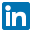
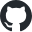
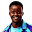
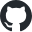

In [22]:
# Fetch User Data
user_data = fetch_data(user_profile_prompt)

# Inspect the user data
user_data.content

From the raw data above, you can see that we need to parse the final output out of the entire trace so we can use it later. Here's a fucntion to extract just the JSON data from the data.

In [23]:
import json
import re

def extract_json_data(content_list):
    """
    Extract the JSON from the last text block that contains profile summary
    """
    # Go through blocks in reverse to find the last one with JSON
    for block in reversed(content_list):
        if hasattr(block, 'type') and block.type == 'text':
            text = block.text.strip()
            
            # Case 1: JSON wrapped in ```json``` code blocks
            json_match = re.search(r'```json\s*(\{.*?\}|\[.*?\])\s*```', text, re.DOTALL)
            if json_match:
                try:
                    json_str = json_match.group(1)
                    return json.loads(json_str)
                except json.JSONDecodeError:
                    continue
            
            # Case 2: JSON starts directly (no code block wrapper)
            if text.startswith('{') or text.startswith('['):
                try:
                    return json.loads(text)
                except json.JSONDecodeError:
                    continue
    
    return None

Now let's inspect that the JSON data is now in the correct format.

1. User data profile data extraction

In [24]:
# Extract user profile data
user_profile_data = extract_json_data(user_data.content)
print(json.dumps(user_profile_data, indent=2))

{
  "profile_summary": {
    "name": "Tony Kipkemboi",
    "current_role": "Senior Developer Advocate at CrewAI",
    "location": "Washington DC-Baltimore Area, United States",
    "industry": "Artificial Intelligence / Developer Relations"
  },
  "platforms": {
    "github": {
      "username": "tonykipkemboi",
      "followers": 372,
      "following": 4,
      "repositories": 134,
      "bio": "Senior Developer Advocate \ud83e\udd51 at @crewAIInc",
      "achievements": [
        "Starstruck x2",
        "Pair Extraordinaire",
        "Public Sponsor",
        "Quickdraw",
        "YOLO",
        "Pull Shark x2"
      ],
      "notable_projects": [
        {
          "name": "crewai-gmail-automation",
          "stars": 154,
          "description": "Multi-agent system that automates Gmail inbox management"
        },
        {
          "name": "resume-optimization-crew",
          "stars": 124,
          "description": "AI-powered resume optimization using CrewAI"
        },
    

Great, the output looks awesome! 🎉 

Now let's run the other two data fetching and extraction.

2. Extract company profile data

In [25]:
# Fetch company data
company_data = fetch_data(company_profile_prompt)

# Extract company profile data
company_profile_data = extract_json_data(company_data.content)
print(json.dumps(company_profile_data, indent=2))

🔍 Fetching data...
✅ Data fetched successfully
{
  "company_overview": {
    "name": "Anthropic PBC",
    "headquarters": "San Francisco, CA",
    "founded": "2021",
    "employee_count": "Estimated 500-1000+ employees (rapidly growing)",
    "business_model": "AI safety and research company developing large language models (Claude family), offering both consumer and enterprise products through APIs and direct access",
    "mission_vision": {
      "mission": "Building reliable, interpretable, and steerable AI systems",
      "vision": "AI systems that people can rely on for the long-term benefit of humanity",
      "core_focus": "AI safety research and responsible development"
    }
  },
  "strategic_position": {
    "industry": "Artificial Intelligence / Large Language Models",
    "market_position": "Top-tier AI company, direct competitor to OpenAI, valued at $170B in 2025 funding discussions",
    "key_differentiators": [
      "AI safety-first approach with Constitutional AI metho

3. Extract employee profile data

In [26]:
# Fetch employee data
employee_data = fetch_data(employee_profile_prompt)

# Extract employee profile data
employee_profile_data = extract_json_data(employee_data.content)
print(json.dumps(employee_profile_data, indent=2))

🔍 Fetching data...
✅ Data fetched successfully
[
  {
    "name": "Alex Albert",
    "current_role": "Developer Relations/Product",
    "department": "Product/Developer Experience",
    "tenure_years": 1,
    "networking_score": 95,
    "relevance": {
      "shared_background": [
        "University background",
        "Tech industry experience"
      ],
      "common_interests": [
        "AI/Developer tools",
        "Education/helping developers",
        "Product evangelism"
      ],
      "mutual_connections": [
        "University of Washington alumni network"
      ]
    },
    "connection_strategy": {
      "approach": "LinkedIn message referencing his work on Claude developer education",
      "conversation_starters": [
        "Claude API adoption strategies",
        "Developer community building",
        "Technical content creation"
      ],
      "value_proposition": "Interest in contributing to developer education and community growth",
      "best_channel": "LinkedIn"
 

Now that we've fetched all the data we need to generate a detailed analysis report, let's save it locally first for backup. 

We'll use this function to save the JSON data inside an `output/` folder in root.

In [27]:
def save_file_locally(data: dict, filename: str) -> None:  
    """
    Save the data to a local JSON file in the output directory.
    Args:
        data: The data to save.
        filename: The name of the file to save the data to.
    Returns:
        None
    """
    try:
        os.makedirs("output", exist_ok=True)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f"✅ Saved: {filename}")
    except Exception as e:
        print(f"❌ Error saving {filename}: {e}")

In [29]:
# Save user profile
user_name = user_profile_data['profile_summary']['name'].replace(' ', '_')
save_file_locally(user_profile_data, f"output/{user_name}_profile.json")

# Save company profile  
company_name = company_profile_data['company_overview']['name'].replace(' ', '_').replace('(', '').replace(')', '')
save_file_locally(company_profile_data, f"output/{company_name}.json")

# Save all employees as one file
save_file_locally(employee_profile_data,f"output/{company_name}_employees.json")

print(f"\n🎉 All 3 files saved successfully!")

✅ Saved: output/Tony_Kipkemboi_profile.json
✅ Saved: output/Anthropic_PBC.json
✅ Saved: output/Anthropic_PBC_employees.json

🎉 All 3 files saved successfully!


## Generate Final Report 

The next step is for us to load the JSON files and return as formatted strings for us to include in the Messages API prompt for final report generation.

First, let's load the data with the function below.

In [34]:
def load_json_files() -> tuple[str, str, str]:
    """
    Load JSON files and return as formatted strings for prompt inclusion.
    
    Returns:
        Tuple of JSON strings (user, company, employee data)
    """
    with open("output/Tony_Kipkemboi_profile.json", 'r') as f:
        user_data = json.load(f)

    with open("output/Anthropic_PBC.json", 'r') as f:
        company_data = json.load(f)

    with open("output/Anthropic_PBC_employees.json", 'r') as f:
        employee_data = json.load(f)

    # Convert back to pretty JSON strings for the Messages API prompt
    return (
        json.dumps(user_data, indent=2),
        json.dumps(company_data, indent=2),
        json.dumps(employee_data, indent=2)
    )

# Load as JSON strings
user_json, company_json, employee_json = load_json_files()

Finally, let's add all the data to the Messages API and our prompt on how to generate a report from the data.

A few things to note:

- I chose to use `claude-opus-4-20250514` for better analysis since it's a much better model; better analysis and report
- Enabled thinking + budget tokens for the model. 

> Please note that the `budget_tokens` value need to be lower than the `max_tokens`

In [35]:
message = anthropic.beta.messages.create(
    model="claude-opus-4-20250514",
    max_tokens=7000,
    thinking={
        "type": "enabled",
        "budget_tokens": 5000
    },
    messages=[
        {
            "role": "user",
            "content": f"""
                You are an expert strategic networking analyst. Analyze the provided datasets to create a comprehensive networking strategy for 
                advancing my career in {target_info['target_role']} at {target_info['company_name']}.

                <task>
                Create a strategic networking report that:
                1. Identifies the 5-7 highest-value connections based on profile compatibility
                2. Provides actionable outreach strategies for each person
                3. Includes timing recommendations and conversation topics
                </task>

                <data>
                <user_profile>
                {user_json}
                </user_profile>

                <company_profile>
                {company_json}
                </company_profile>

                <employee_profiles>
                {employee_json}
                </employee_profiles>
                </data>

                <output_requirements>
                Structure your report with these sections:

                1. EXECUTIVE SUMMARY
                    - Key insights about networking opportunities
                    - Top 3 immediate action items

                2. CONNECTION RANKINGS
                    For each recommended connection (5-7 people):
                    - Name and role
                    - Compatibility score (1-10) with rationale
                    - Shared interests/background
                    - Strategic value for my career goals

                3. OUTREACH STRATEGIES
                    For each top connection:
                    - Personalized message (150 chars max)
                    - Best platform for contact
                    - Optimal timing
                    - Follow-up approach

                4. CONVERSATION STARTERS
                    - 5 insightful questions about the company
                    - 3 topics relevant to each connection's interests

                5. TACTICAL ROADMAP
                    - Week-by-week networking plan
                    - Success metrics to track

                Format as clean markdown without code blocks or XML tags.
                </output_requirements>"""
        }
    ]
)

Now that the final report is ready, let's save it as a Markdown file so we can read and do whatever we please with it! 

In [37]:
# Save final output to a markdown file
from datetime import datetime

filename = f"networking_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
with open(filename, 'w', encoding='utf-8') as f:
    f.write(f"{message.content[1].text}")

print(f"✅ Saved to {filename}")

✅ Saved to networking_analysis_20250803_132612.md


## Congratulations! 🚀

If you've gotten this far, you've learnt quite a lot about how to use **Claude's MCP connector** + the **Messages API** with thinking enabled.